In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/supplementary-data-working/final_val.json
/kaggle/input/supplementary-data-working/final_train.json
/kaggle/input/supplementary-data-working/final_test.json
/kaggle/input/mpnet-text-features/Test_text_Drob_Feature_mpnet.pt
/kaggle/input/mpnet-text-features/Val_text_Drob_Feature_mpnet.pt
/kaggle/input/mpnet-text-features/Train_text_Drob_Feature_mpnet.pt
/kaggle/input/minilm-text-features/Val_text_Drob_Feature_MiniLM.pt
/kaggle/input/minilm-text-features/Train_text_Drob_Feature_MiniLM.pt
/kaggle/input/minilm-text-features/Test_text_Drob_Feature_MiniLM.pt
/kaggle/input/distilroberta-text-features/Test_text_Drob_Feature_distilroberta.pt
/kaggle/input/distilroberta-text-features/Train_text_Drob_Feature_distilroberta.pt
/kaggle/input/distilroberta-text-features/Val_text_Drob_Feature_distilroberta.pt
/kaggle/input/harmeme/MINI_PROJECT_2/requirements.txt
/kaggle/input/harmeme/MINI_PROJECT_2/harmeme_saved_feat_ROIENT/harmeme_ENT_MOMENTA/cov/harmeme_cov_target/harmeme_cov_val_ent.p

In [2]:
!pip install git+https://github.com/PetrochukM/PyTorch-NLP.git

  Cloning https://github.com/PetrochukM/PyTorch-NLP.git to /tmp/pip-req-build-qqgjvudl
  Running command git clone --filter=blob:none --quiet https://github.com/PetrochukM/PyTorch-NLP.git /tmp/pip-req-build-qqgjvudl
  Resolved https://github.com/PetrochukM/PyTorch-NLP.git to commit 53d7edcb8e0c099efce7c2ddf8cd7c44157fcac3
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-nlp: filename=pytorch_nlp-0.5.0-py3-none-any.whl size=88719 sha256=102215049a76f32ce37df8f49a56c819daa3c5ecffb605ec9f1f0bda0e29c8dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-edodp0w0/wheels/a5/93/b0/9f0138afb1271281613a5af71272c5b246fdd2d421c6fbdf88
Successfully built pytorch-nlp


In [3]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchnlp import encoders
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import  mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from pathlib import Path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda


In [4]:
torch.cuda.empty_cache()

In [5]:
# Load the ROI features (Covid)
train_ROI = torch.load("/kaggle/input/harmeme/MINI_PROJECT_2/harmeme_saved_feat_ROIENT/harmeme_ROI_MOMENTA/cov/memes_harmfulness/harmeme_cov_train_ROI.pt")
val_ROI = torch.load("/kaggle/input/harmeme/MINI_PROJECT_2/harmeme_saved_feat_ROIENT/harmeme_ROI_MOMENTA/cov/memes_harmfulness/harmeme_cov_val_ROI.pt")
test_ROI = torch.load("/kaggle/input/harmeme/MINI_PROJECT_2/harmeme_saved_feat_ROIENT/harmeme_ROI_MOMENTA/cov/memes_harmfulness/harmeme_cov_test_ROI.pt")
# Load the ENT features
train_ENT = torch.load("/kaggle/input/mpnet-text-features/Train_text_Drob_Feature_mpnet.pt")
val_ENT = torch.load("/kaggle/input/mpnet-text-features/Val_text_Drob_Feature_mpnet.pt")
test_ENT = torch.load("/kaggle/input/mpnet-text-features/Test_text_Drob_Feature_mpnet.pt")

In [6]:
data_dir_cov = "/kaggle/input/harmeme/MINI_PROJECT_2/Harm-C/datasets/memes/defaults/images"
train_path_cov = "/kaggle/input/d/yashnikam10/supplementary-data/final_train.json"
dev_path_cov   = "/kaggle/input/d/yashnikam10/supplementary-data/final_val_dict.json"
test_path_cov  = "/kaggle/input/d/yashnikam10/supplementary-data/final_test.json"

In [7]:
train_samples_frame = pd.read_json(train_path_cov, lines=True)
train_samples_frame.head()

,id,image,labels,text,bb_dict
0,covid_memes_18,covid_memes_18.png,"[somewhat harmful, individual]",Bernie or Elizabeth?\nBe informed.Compare them...,"[[0.6680887372013651, 0.632857142857142, 0.825..."
1,covid_memes_19,covid_memes_19.png,"[somewhat harmful, organization]",Extending the\nBrexit deadline until\nOctober ...,[]
2,covid_memes_252,covid_memes_252.png,[not harmful],kwai\ngkwa 0964\n#nnevvy\napplause to Thais fr...,"[[0.522067189216613, 0.207160174846649, 0.4088..."
3,covid_memes_255,covid_memes_255.png,[not harmful],"So, I order this\nfoce mask to\nprotect ogains...",[]
4,covid_memes_20,covid_memes_20.png,"[somewhat harmful, individual]",best candidate for\nJA\n2020\njoe biden\nKamal...,"[[0.47865853658536506, 0.32835820895522305, 0...."


In [8]:
test_samples_frame = pd.read_json(test_path_cov, lines=True)
test_samples_frame.head()

,id,image,labels,text,bb_dict
0,covid_memes_5425,covid_memes_5425.png,[not harmful],gwen\n@gwenervi\ndis gon be trump tomorrow aft...,[]
1,covid_memes_5426,covid_memes_5426.png,[not harmful],Armani\n@historyofarmani\nBiden after hearing ...,"[[0.071942446043165, 0.2734375, 0.393884892086..."
2,covid_memes_5429,covid_memes_5429.png,[not harmful],MESSAGE FROM TRUMP TO\nCOVID-19\nLEAVE NOW OR ...,"[[0.41454545454545405, 0.125683060109289, 0.64..."
3,covid_memes_5430,covid_memes_5430.png,[not harmful],COVID-19 STARTED DURING HIS TERM\nSOIT SHOULD ...,"[[0.257246376811594, 0.19125683060109203, 0.54..."
4,covid_memes_5434,covid_memes_5434.png,[not harmful],TRUMPS RESPONSE TO COVID-19\nUMP\nTAYM\nINCLUD...,"[[0.25703868269920305, 0.167230486869812, 0.49..."


In [9]:
!pip install ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.3 MB/s eta 0:00:00


In [10]:
import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re

In [11]:
!wget -O bpe_simple_vocab_16e6.txt.gz https://drive.google.com/uc?id=1YNkhStUg9YJ3WPUeCWhHyyMUmVqlWrG5

--2023-11-05 13:02:33--  https://drive.google.com/uc?id=1YNkhStUg9YJ3WPUeCWhHyyMUmVqlWrG5
Resolving drive.google.com (drive.google.com)... 173.194.192.101, 173.194.192.102, 173.194.192.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.192.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-a8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ckd3m0pg095g9ahic22993ak9pcq8f9v/1699189350000/14204125426768851410/*/1YNkhStUg9YJ3WPUeCWhHyyMUmVqlWrG5?uuid=40262111-79f4-47f5-8b56-7dca484d41d7 [following]
--2023-11-05 13:02:34--  https://doc-0s-a8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ckd3m0pg095g9ahic22993ak9pcq8f9v/1699189350000/14204125426768851410/*/1YNkhStUg9YJ3WPUeCWhHyyMUmVqlWrG5?uuid=40262111-79f4-47f5-8b56-7dca484d41d7
Resolving doc-0s-a8-docs.googleusercontent.com (doc-0s-a8-docs.googleusercontent.com)... 108.177.111.132, 2607:f8b0:4001:c07::84
Connecting to d

In [12]:
@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "/kaggle/working/bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
#         with gzip.open(bpe_path,'w') as t:
#        with gzip.open(bpe_path,'rt', encoding="utf-8") as f:
#                merges = f.read()
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        #print(merges)
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        #print(vocab)
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text

In [13]:
# Downloadig the clip model
MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",    
}
! wget {MODELS["ViT-B/32"]} -O clip_model.pt

--2023-11-05 13:02:35--  https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.38, 13.107.213.38, 2620:1ec:bdf::38, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353976522 (338M) [application/octet-stream]
Saving to: ‘clip_model.pt’

clip_model.pt       100%[===================>] 337.58M   135MB/s    in 2.5s    

2023-11-05 13:02:38 (135 MB/s) - ‘clip_model.pt’ saved [353976522/353976522]



In [14]:
clip_model = torch.jit.load("clip_model.pt").cuda().eval()
input_resolution = clip_model.input_resolution.item()
context_length = clip_model.context_length.item()
vocab_size = clip_model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [15]:
preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
    ])
tokenizer = SimpleTokenizer()

In [16]:
def process_image_clip(in_img):
    image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
    image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()
    
    image = preprocess(Image.open(in_img).convert("RGB"))
    
    image_input = torch.tensor(np.stack(image)).cuda()
    image_input -= image_mean[:, None, None]
    image_input /= image_std[:, None, None]
    return image_input

In [17]:
def process_text_clip(in_text):    
    text_token = tokenizer.encode(in_text)
    text_input = torch.zeros(clip_model.context_length, dtype=torch.long)
    sot_token = tokenizer.encoder['<|startoftext|>']
    eot_token = tokenizer.encoder['<|endoftext|>']
    tokens = [sot_token] + text_token[:75] + [eot_token]
    text_input[:len(tokens)] = torch.tensor(tokens)
    text_input = text_input.cuda()
    return text_input

In [18]:
import torch
from torch import optim, nn
from torchvision import models, transforms
import cv2

In [19]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # Extract the feature layers from the Vision Transformer model
        self.features = nn.Sequential(*list(model.children())[:-1])
        self.conv = self.features[0]
        self.encoder = self.features[1]
        self.model = model

    def forward(self, img):
        x = self.model._process_input(img)
        n = x.shape[0]
        batch_class_token = self.model.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)
        x = self.encoder(x)
        out = x[:,0]
        return out 

# Initialize the model
model_vit_pretrained = models.vit_b_16(pretrained=True)
model_vit = FeatureExtractor(model_vit_pretrained)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
model_vit = model_vit.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 257MB/s]  


In [20]:
from tqdm import tqdm
import numpy as np

In [21]:
transform_vit_BB = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize((224,224)),
  transforms.ToTensor()                              
])

In [22]:
def get_image_vit_BB(l, t, r, b, in_im): 
    img = cv2.imread(in_im)
    h, w, _ = img.shape
    x1 = int(np.floor(l*w))
    x2 = int(np.floor(r*w))
    y1 = int(np.floor(b*h))
    y2 = int(np.floor(t*h))
    crop_img = img[y1:y2, x1:x2]    
    
    img = transform_vit_BB(crop_img)
    # [batch_size, channels, width, height]
    img = img.reshape(1, 3, 224, 224)
    img = img.to(device)
    with torch.no_grad():
        feature = model_vit(img).squeeze()
    return feature

In [23]:
from tqdm import tqdm
import numpy as np

transform_vit_center = transforms.Compose([
  transforms.ToPILImage(),
  transforms.CenterCrop(512),
  transforms.Resize(224),
  transforms.ToTensor()                              
])

In [24]:
def get_image_vit_center(in_im):
    path = in_im
    img = cv2.imread(path)
    img = transform_vit_center(img)
    img = img.reshape(1, 3, 224, 224)
    img = img.to(device)
    with torch.no_grad():
        feature = model_vit(img).squeeze()
    
    return feature

In [25]:
# !pip install git+https://github.com/UKPLab/sentence-transformers

In [26]:
# from sentence_transformers import SentenceTransformer
# model_sent_trans = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [27]:
class HarmemeMemesDatasetAug2(torch.utils.data.Dataset):
    """Uses jsonl data to preprocess and serve 
    dictionary of multimodal tensors for model input.
    """

    def __init__(
        self,
        data_path,
        img_dir,
        split_flag=None,
        balance=False,
        dev_limit=None,
        random_state=0,
    ):

        self.samples_frame = pd.read_json(
            data_path, lines=True
        )
        self.samples_frame = self.samples_frame.reset_index(
            drop=True
        )
        self.samples_frame.image = self.samples_frame.apply(
            lambda row: (img_dir + '/' + row.image), axis=1
        )
        if split_flag=='train':
            self.ROI_samples = train_ROI
            self.ENT_samples = train_ENT
        elif split_flag=='val':
            self.ROI_samples = val_ROI
            self.ENT_samples = val_ENT
        else:
            self.ROI_samples = test_ROI
            self.ENT_samples = test_ENT
        
    def __len__(self):
        """This method is called when you do len(instance) 
        for an instance of this class.
        """
        return len(self.samples_frame)

    def __getitem__(self, idx):
        """This method is called when you do instance[key] 
        for an instance of this class.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.samples_frame.loc[idx, "id"]
        img_file_name = self.samples_frame.loc[idx, "image"]
        
        image_clip_input = process_image_clip(self.samples_frame.loc[idx, "image"])
        BB_info = self.samples_frame.loc[idx, "bb_dict"]
        roi_vit_feat_list = []
        if BB_info:
            total_BB = len(BB_info)
            if total_BB>4:
                BB_info_final = BB_info[:4]
            else:
                BB_info_final = BB_info             
            for item in BB_info_final:              
                left   = item[0]
                bottom = item[1]
                top    = bottom + item[3]
                right  = left + item[2]
                get_image_vit_center(img_file_name)
                roi_vit_feat = get_image_vit_BB(left, top, right, bottom, img_file_name)
                roi_vit_feat_list.append(roi_vit_feat)
            image_vit_feature = torch.mean(torch.vstack(roi_vit_feat_list), axis=0)
        else:
            image_vit_feature = torch.tensor(get_image_vit_center(img_file_name))
# --------------------------------------------------------------------------------------
        text_clip_input = process_text_clip(self.samples_frame.loc[idx, "text"])
#         -------------------------------------------------------------------------------
        text_drob_feature = self.ENT_samples[idx]

        if "labels" in self.samples_frame.columns:
            if self.samples_frame.loc[idx, "labels"][0]=="not harmful":
                lab=0
            elif self.samples_frame.loc[idx, "labels"][0]=="somewhat harmful":
                lab=1  
            else:
                lab=2
            label = torch.tensor(lab).to(device)  

            
            sample = {
                "id": img_id, 
                "image_clip_input": image_clip_input,
                "image_vit_feature": image_vit_feature,
                "text_clip_input": text_clip_input,
                "text_drob_embedding": text_drob_feature,
                "label": label
            }
        else:
            sample = {
                "id": img_id, 
                "image_clip_input": image_clip_input,
                "image_vit_feature": image_vit_feature,
                "text_clip_input": text_clip_input,
                "text_drob_embedding": text_drob_feature
            }

        return sample

In [28]:
hm_dataset_train = HarmemeMemesDatasetAug2(train_path_cov, data_dir_cov, 'train')
dataloader_train = DataLoader(hm_dataset_train, batch_size=64,
                        shuffle=True, num_workers=0)
hm_dataset_val = HarmemeMemesDatasetAug2(dev_path_cov, data_dir_cov, 'val')
dataloader_val = DataLoader(hm_dataset_val, batch_size=64,
                        shuffle=True, num_workers=0)
hm_dataset_test = HarmemeMemesDatasetAug2(test_path_cov, data_dir_cov, 'test')
dataloader_test = DataLoader(hm_dataset_test, batch_size=64,
                        shuffle=False, num_workers=0)

In [29]:
class MM(nn.Module):
    def __init__(self, n_out):
        super(MM, self).__init__()  
        
        self.dense_vit_512 = nn.Linear(768, 512)
        self.drop20 = nn.Dropout(p=0.2)
        self.drop5 = nn.Dropout(p=0.05) 
        
        self.dense_drob_512 = nn.Linear(768, 512)
        
        self.gen_key_L1 = nn.Linear(512, 256) # 512X256
        self.gen_query_L1 = nn.Linear(512, 256) # 512X256
        self.gen_key_L2 = nn.Linear(512, 256) # 512X256
        self.gen_query_L2 = nn.Linear(512, 256) # 512X256
        self.gen_key_L3 = nn.Linear(512, 256) # 512X256
        self.gen_query_L3 = nn.Linear(512, 256) # 512X256
        self.soft = nn.Softmax(dim=1)
        self.soft_final = nn.Softmax(dim=1)
        self.project_dense_512a = nn.Linear(1024, 512) # 512X256
        self.project_dense_512b = nn.Linear(1024, 512) # 512X256
        self.project_dense_512c = nn.Linear(1024, 512) # 512X256 
        
        
        self.fc_out = nn.Linear(512, 256) # 512X256
        self.out = nn.Linear(256, n_out) # 512X256
        

    def selfattNFuse_L1a(self, vec1, vec2): 
            q1 = F.relu(self.gen_query_L1(vec1))
            k1 = F.relu(self.gen_key_L1(vec1))
            q2 = F.relu(self.gen_query_L1(vec2))
            k2 = F.relu(self.gen_key_L1(vec2))
            score1 = torch.reshape(torch.bmm(q1.view(-1, 1, 256), k2.view(-1, 256, 1)), (-1, 1))
            score2 = torch.reshape(torch.bmm(q2.view(-1, 1, 256), k1.view(-1, 256, 1)), (-1, 1))
            wt_score1_score2_mat = torch.cat((score1, score2), 1)
            wt_i1_i2 = self.soft(wt_score1_score2_mat.float()) #prob
            prob_1 = wt_i1_i2[:,0]
            prob_2 = wt_i1_i2[:,1]
            wtd_i1 = vec1 * prob_1[:, None]
            wtd_i2 = vec2 * prob_2[:, None]
            out_rep = F.relu(self.project_dense_512a(torch.cat((wtd_i1,wtd_i2), 1)))
            return out_rep
    def selfattNFuse_L1b(self, vec1, vec2): 
            q1 = F.relu(self.gen_query_L2(vec1))
            k1 = F.relu(self.gen_key_L2(vec1))
            q2 = F.relu(self.gen_query_L2(vec2))
            k2 = F.relu(self.gen_key_L2(vec2))
            score1 = torch.reshape(torch.bmm(q1.view(-1, 1, 256), k2.view(-1, 256, 1)), (-1, 1))
            score2 = torch.reshape(torch.bmm(q2.view(-1, 1, 256), k1.view(-1, 256, 1)), (-1, 1))
            wt_score1_score2_mat = torch.cat((score1, score2), 1)
            wt_i1_i2 = self.soft(wt_score1_score2_mat.float()) #prob
            prob_1 = wt_i1_i2[:,0]
            prob_2 = wt_i1_i2[:,1]
            wtd_i1 = vec1 * prob_1[:, None]
            wtd_i2 = vec2 * prob_2[:, None]
            out_rep = F.relu(self.project_dense_512b(torch.cat((wtd_i1,wtd_i2), 1)))
            return out_rep
    
    def selfattNFuse_L2(self, vec1, vec2): 
            q1 = F.relu(self.gen_query_L3(vec1))
            k1 = F.relu(self.gen_key_L3(vec1))
            q2 = F.relu(self.gen_query_L3(vec2))
            k2 = F.relu(self.gen_key_L3(vec2))
            score1 = torch.reshape(torch.bmm(q1.view(-1, 1, 256), k2.view(-1, 256, 1)), (-1, 1))
            score2 = torch.reshape(torch.bmm(q2.view(-1, 1, 256), k1.view(-1, 256, 1)), (-1, 1))
            wt_score1_score2_mat = torch.cat((score1, score2), 1)
            wt_i1_i2 = self.soft(wt_score1_score2_mat.float()) #prob
            prob_1 = wt_i1_i2[:,0]
            prob_2 = wt_i1_i2[:,1]
            wtd_i1 = vec1 * prob_1[:, None]
            wtd_i2 = vec2 * prob_2[:, None]
            out_rep = F.relu(self.project_dense_512c(torch.cat((wtd_i1,wtd_i2), 1)))
            return out_rep


    def forward(self, in_CI, in_VIT, in_CT, in_Drob):        
        VIT_feat = self.drop20(F.relu(self.dense_vit_512((in_VIT))))
        Drob_feat = self.drop5(F.relu(self.dense_drob_512(in_Drob)))
        out_img = self.selfattNFuse_L1a(VIT_feat, in_CI)
        out_txt = self.selfattNFuse_L1b(Drob_feat, in_CT)        
        out_img_txt = self.selfattNFuse_L2(out_img, out_txt)
        final_out = F.relu(self.fc_out(out_img_txt))
        out = self.out(final_out)
        return out

In [30]:
output_size = 3
exp_name = "EMNLP_MCHarm_GLAREAll_COVTrain_POLEval"
exp_path = "/kaggle/working/EMNLP_ModelCkpt/"+exp_name
lr=0.001
criterion = nn.CrossEntropyLoss()
model = MM(output_size)
model.to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

MM(
  (dense_vit_512): Linear(in_features=768, out_features=512, bias=True)
  (drop20): Dropout(p=0.2, inplace=False)
  (drop5): Dropout(p=0.05, inplace=False)
  (dense_drob_512): Linear(in_features=768, out_features=512, bias=True)
  (gen_key_L1): Linear(in_features=512, out_features=256, bias=True)
  (gen_query_L1): Linear(in_features=512, out_features=256, bias=True)
  (gen_key_L2): Linear(in_features=512, out_features=256, bias=True)
  (gen_query_L2): Linear(in_features=512, out_features=256, bias=True)
  (gen_key_L3): Linear(in_features=512, out_features=256, bias=True)
  (gen_query_L3): Linear(in_features=512, out_features=256, bias=True)
  (soft): Softmax(dim=1)
  (soft_final): Softmax(dim=1)
  (project_dense_512a): Linear(in_features=1024, out_features=512, bias=True)
  (project_dense_512b): Linear(in_features=1024, out_features=512, bias=True)
  (project_dense_512c): Linear(in_features=1024, out_features=512, bias=True)
  (fc_out): Linear(in_features=512, out_features=256, bia

In [31]:
! nvcc --version
! nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Sun Nov  5 13:02:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    31W /  70W |   1330MiB / 15109MiB |      0%      Default |
|                               |       

In [32]:
!git clone https://github.com/Bjarten/early-stopping-pytorch

Cloning into 'early-stopping-pytorch'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Receiving objects: 100% (92/92), 533.89 KiB | 3.51 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [33]:
!pip install -r early-stopping-pytorch/requirements.txt

In [34]:
!cp early-stopping-pytorch/pytorchtools.py .

In [35]:
import os, sys
from pytorchtools import EarlyStopping

In [36]:
def train_model(model, patience, n_epochs):
    epochs = n_epochs
#     clip = 5

    train_acc_list=[]
    val_acc_list=[]
    train_loss_list=[]
    val_loss_list=[]
    
        # initialize the experiment path
    Path(exp_path).mkdir(parents=True, exist_ok=True)
    # initialize early_stopping object
    chk_file = os.path.join(exp_path, 'checkpoint_'+exp_name+'.pt')
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=chk_file)


    model.train()
    for i in range(epochs):
#         total_acc_train = 0
        total_loss_train = 0
        total_train = 0
        correct_train = 0

        for data in dataloader_train:
            
#             Clip features...
            img_inp_clip = data['image_clip_input']
            txt_inp_clip = data['text_clip_input']
            with torch.no_grad():
                img_feat_clip = clip_model.encode_image(img_inp_clip).float().to(device)
                txt_feat_clip = clip_model.encode_text(txt_inp_clip).float().to(device)

            img_feat_vit = data['image_vit_feature']
            txt_feat_trans = data['text_drob_embedding']

            label_train = data['label'].to(device)

            model.zero_grad()
            output = model(img_feat_clip, img_feat_vit, txt_feat_clip, txt_feat_trans)

            loss = criterion(output.squeeze(), label_train)
            
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                _, predicted_train = torch.max(output.data, 1)
                total_train += label_train.size(0)
                correct_train += (predicted_train == label_train).sum().item()
                total_loss_train += loss.item()

        
        train_acc = 100 * correct_train / total_train
        train_loss = total_loss_train/total_train
        model.eval()
#         total_acc_val = 0
        total_loss_val = 0
        total_val = 0
        correct_val = 0

        with torch.no_grad():
            for data in dataloader_val:                
#                 Clip features...                
                img_inp_clip = data['image_clip_input']
                txt_inp_clip = data['text_clip_input']
                with torch.no_grad():
                    img_feat_clip = clip_model.encode_image(img_inp_clip).float().to(device)
                    txt_feat_clip = clip_model.encode_text(txt_inp_clip).float().to(device)
                
                
                img_feat_vit = data['image_vit_feature']                
                txt_feat_trans = data['text_drob_embedding']

                

                label_val = data['label'].to(device)

                model.zero_grad()
                
                output = model(img_feat_clip, img_feat_vit, txt_feat_clip, txt_feat_trans)
#                 output = model(img_feat_vgg, txt_feat_trans)
                
                
                val_loss = criterion(output.squeeze(), label_val)
                _, predicted_val = torch.max(output.data, 1)
                total_val += label_val.size(0)
                correct_val += (predicted_val == label_val).sum().item()                
                total_loss_val += val_loss.item()
        print("Saving model...") 
        torch.save(model.state_dict(), os.path.join(exp_path, "final.pt"))

        val_acc = 100 * correct_val / total_val
        val_loss = total_loss_val/total_val

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
        print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        model.train()
        torch.cuda.empty_cache()
    
    return  model, train_acc_list, val_acc_list, train_loss_list, val_loss_list, i

In [37]:
def test_model(model):
    model.eval()
    total_test = 0
    correct_test =0
    total_acc_test = 0
    total_loss_test = 0
    outputs = []
    test_labels=[]
    with torch.no_grad():
        for data in dataloader_test:
            img_inp_clip = data['image_clip_input']
            txt_inp_clip = data['text_clip_input']
            with torch.no_grad():
                img_feat_clip = clip_model.encode_image(img_inp_clip).float().to(device)
                txt_feat_clip = clip_model.encode_text(txt_inp_clip).float().to(device)

            img_feat_vit = data['image_vit_feature']
            txt_feat_trans = data['text_drob_embedding']            

            label_test = data['label'].to(device)
                   

            out = model(img_feat_clip, img_feat_vit, txt_feat_clip, txt_feat_trans)        

            outputs += list(out.cpu().data.numpy())
            loss = criterion(out.squeeze(), label_test)
            
            _, predicted_test = torch.max(out.data, 1)
            total_test += label_test.size(0)
            correct_test += (predicted_test == label_test).sum().item()
            total_loss_test += loss.item()

    acc_test = 100 * correct_test / total_test
    loss_test = total_loss_test/total_test   
    
    print(f'acc: {acc_test:.4f} loss: {loss_test:.4f}')
    return outputs

In [38]:
n_epochs = 1
# early stopping patience; how long to wait after last time validation loss improved.
patience = 1
model, train_acc_list, val_acc_list, train_loss_list, val_loss_list, epoc_num = train_model(model, patience, n_epochs)

/tmp/ipykernel_32/1005603588.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_vit_feature = torch.tensor(get_image_vit_center(img_file_name))
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incor

Saving model...
Validation loss decreased (inf --> 0.012623).  Saving model ...
Epoch 1: train_loss: 0.0111 train_acc: 70.7600 | val_loss: 0.0126 val_acc: 67.7966


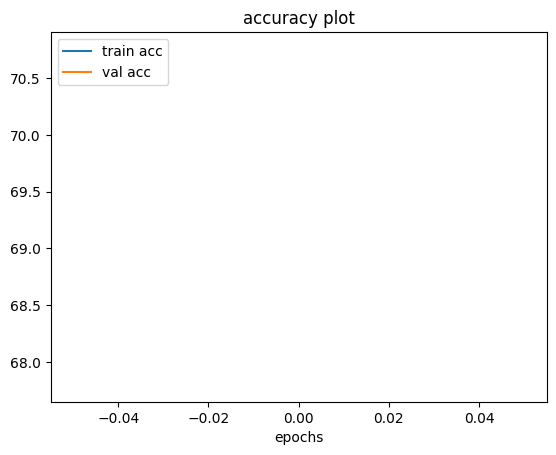

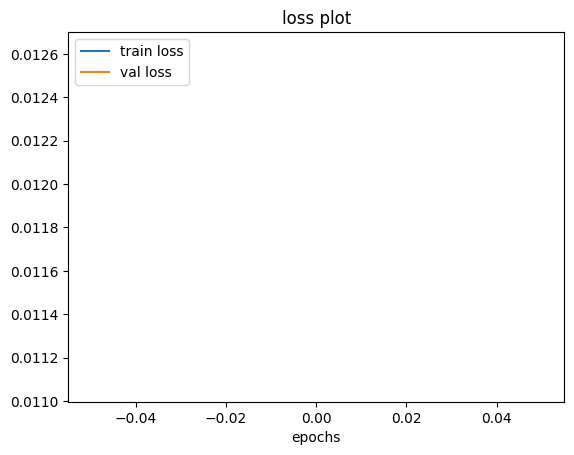

In [39]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
epochs = range(epoc_num+1)
train_acc_list
val_acc_list
train_loss_list
val_loss_list
# plt.plot(epochs, train_acc_list)
# plt.plot(epochs, val_acc_list)
fig1, ax1 = plt.subplots()
ax1.plot(epochs, train_acc_list, label="train acc")
ax1.plot(epochs, val_acc_list, label="val acc")
ax1.set_title("accuracy plot")
ax1.set_xlabel("epochs")
ax1.legend(loc="upper left")
fig2, ax2 = plt.subplots()
ax2.plot(epochs, train_loss_list, label="train loss")
ax2.plot(epochs, val_loss_list, label="val loss")
ax2.set_title("loss plot")
ax2.set_xlabel("epochs")
ax2.legend(loc="upper left")

In [40]:
outputs = test_model(model)

/tmp/ipykernel_32/1005603588.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_vit_feature = torch.tensor(get_image_vit_center(img_file_name))
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


acc: 77.4011 loss: 0.0093


In [41]:
y_pred=[]
for i in outputs:
    y_pred.append(np.argmax(i))

test_labels=[]
for index, row in test_samples_frame.iterrows():
    lab = row['labels'][0]
    if lab=="not harmful":
        test_labels.append(0)
    elif lab=="somewhat harmful":
        test_labels.append(1)
    else:
        test_labels.append(2)

In [42]:
def calculate_mmae(expected, predicted, classes):
    NUM_CLASSES = len(classes)
    count_dict = {}
    dist_dict = {}
    for i in range(NUM_CLASSES):
        count_dict[i] = 0
        dist_dict[i] = 0.0
    for i in range(len(expected)):
        dist_dict[expected[i]] += abs(expected[i] - predicted[i])
        count_dict[expected[i]] += 1
    overall = 0.0
    for claz in range(NUM_CLASSES): 
        class_dist =  1.0 * dist_dict[claz] / count_dict[claz] 
        overall += class_dist
    overall /= NUM_CLASSES
    return overall

In [43]:
rec = np.round(recall_score(test_labels, y_pred, average="macro"),4)
prec = np.round(precision_score(test_labels, y_pred, average="macro"),4)
f1 = np.round(f1_score(test_labels, y_pred, average="macro"),4)
acc = np.round(accuracy_score(test_labels, y_pred),4)
mmae = np.round(calculate_mmae(test_labels, y_pred, [0,1,2]),4)
mae = np.round(mean_absolute_error(test_labels, y_pred),4)
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       230
           1       0.58      0.90      0.70       103
           2       0.00      0.00      0.00        21

    accuracy                           0.77       354
   macro avg       0.51      0.56      0.52       354
weighted avg       0.78      0.77      0.76       354



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

In [44]:
print("Acc, F1, Rec, Prec, MAE, MMAE")
print(acc, f1, rec, prec, mae, mmae)

Acc, F1, Rec, Prec, MAE, MMAE
0.774 0.5201 0.5633 0.5052 0.2316 0.4685


Binary Metrics

In [45]:
y_pred_binary = [0 if c == 0 else 1 for c in y_pred]
test_labels_binary = [0 if c == 0 else 1 for c in test_labels]

In [46]:
rec_binary = np.round(recall_score(test_labels_binary, y_pred_binary, average="macro"),4)
prec_binary = np.round(precision_score(test_labels_binary, y_pred_binary, average="macro"),4)
f1_binary = np.round(f1_score(test_labels_binary, y_pred_binary, average="macro"),4)
# hl = np.round(hamming_loss(test_labels, y_pred),4)
acc_binary = np.round(accuracy_score(test_labels_binary, y_pred_binary),4)
#mmae_binary = np.round(calculate_mmae(test_labels_binary, y_pred_binary, [0,1,2]),4)
mae_binary = np.round(mean_absolute_error(test_labels_binary, y_pred_binary),4)
print(classification_report(test_labels_binary, y_pred_binary))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       230
           1       0.70      0.90      0.79       124

    accuracy                           0.83       354
   macro avg       0.82      0.85      0.82       354
weighted avg       0.85      0.83      0.83       354



In [47]:
print("Acc, F1, Rec, Prec, MAE")#, MMAE")
print(acc_binary, f1_binary, rec_binary, prec_binary, mae_binary)#, mmae_binary)

Acc, F1, Rec, Prec, MAE
0.8277 0.8209 0.8451 0.8167 0.1723
